# **Moving Average Convergence/Divergence (MACD) in FAANG Security Data**
---

### Import Libraries

In [1]:
import os
import warnings

import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 227

from sklearn.metrics import accuracy_score

warnings.filterwarnings('ignore')

### Import Data

In [10]:
ticker = 'FB'
#ticker = 'AAPL'
#ticker = 'AMZN'
#ticker = 'NFLX'
#ticker = 'GOOG'

year = '2019'
budgetM = 15000

# Colors
lightblue = '#4ac2fb'
darkblue = '#3388cf'
pinkyred = '#ff4e97'
darkpink = '#cc3d78'
limegreen = '#b7de24'
darkgreen = '#96b71c'
purple = '#ad6eff'
orange = '#ffbd74'
orange2 = '#ffa33f'
red = '#ff005e'
green = '#4bd81d'
black= '#333333'

In [3]:
files = os.listdir('data/stocks')
stocks = {}
for file in files:
    if file.split('.')[1] == 'csv':
        name = file.split('.')[0]
        stocks[name] = pd.read_csv('data/stocks/'+file, index_col='Date')
        stocks[name].index = pd.to_datetime(stocks[name].index)
print(files)

['amzn.csv', 'fb.csv', 'nflx.csv', 'goog.csv', '.ipynb_checkpoints', 'aapl.csv']


---
# Moving Average Convergence/Divergence (MACD) to Make Decisions
---

In [4]:
def trading_history(stock, net, std=2):
    plt.figure(figsize=(16,5))
    plt.style.use('seaborn-whitegrid')
    
    plt.plot(stock.index, stock.Close, color=darkblue, label='Price')
    plt.plot(stock.index, stock.MA21, color=purple, label='Moving Average (21 Days)')
    plt.plot(stock.index, stock.Upper_Band, color=orange, alpha=0.3)
    plt.plot(stock.index, stock.Lower_Band, color=orange2, alpha=0.3)
    plt.fill_between(stock.index, stock.Upper_Band, stock.Lower_Band, color=orange2, alpha=0.1, label='Bollinger Band ({} STD)'.format(std))
    
    plt.title('Trading History of {}'.format(ticker.upper()), fontsize=20)
    plt.ylabel('Price', fontsize=12)
    plt.xlim([stock.index.min(), stock.index.max()])
    
    for i in net:
        if i[2] == 1: color=green
        else: color = red
        plt.plot_date(i[0], i[1], color=color)
    
    plt.plot_date([],[], label='Buy', c=green)
    plt.plot_date([],[], label='Sell', c=red)
    
    plt.legend(frameon=True, loc=1, ncol=1, fontsize=10, borderpad=.8)
    plt.show()

In [11]:
def macd_trading(stock, budget, show_graph=True, show_return=True):
    
    state_check = lambda x, y: 1 if x > y else 0 
    stock = stock.reset_index()
    money = budgetM 
    prev_state = state_check(stock.loc[0].MACD, stock.loc[0].Signal) 
    stock_amt = 0 
    net = []
    
    for i in range(1, len(stock)):
        today = stock.iloc[i]
        state = state_check(today.MACD, today.Signal)
        
        if state != prev_state:
            #Buy
            if (today.MACD > today.Signal) and (money != 0):
                stock_amt = int(money/today.Close)
                money = 0 
                net.append([today.Date, today.Close, 1, stock_amt * today.Close])
            #Sell
            if (today.MACD < today.Signal) and (stock_amt != 0):
                money = stock_amt * today.Close
                stock_amt = 0 
                net.append([today.Date, today.Close, 0, money])
                
        prev_state = state
    profit = net[-1][3] - budget 
    
    if show_return == True:
        print('Number of Trades: ', len(net))
        print('Time Frame: {} days'.format((net[-1][0] - net[0][0]).days))
        print('Profit: ${:.2f} | {}%'.format(profit,round(profit/budget*100,2)))
        
    if show_graph == True:
        trading_history(stock.set_index('Date'),net)
    
    return profit, net
    

Number of Trades:  15
Time Frame: 349 days
Profit: $6224.18 | 41.49%


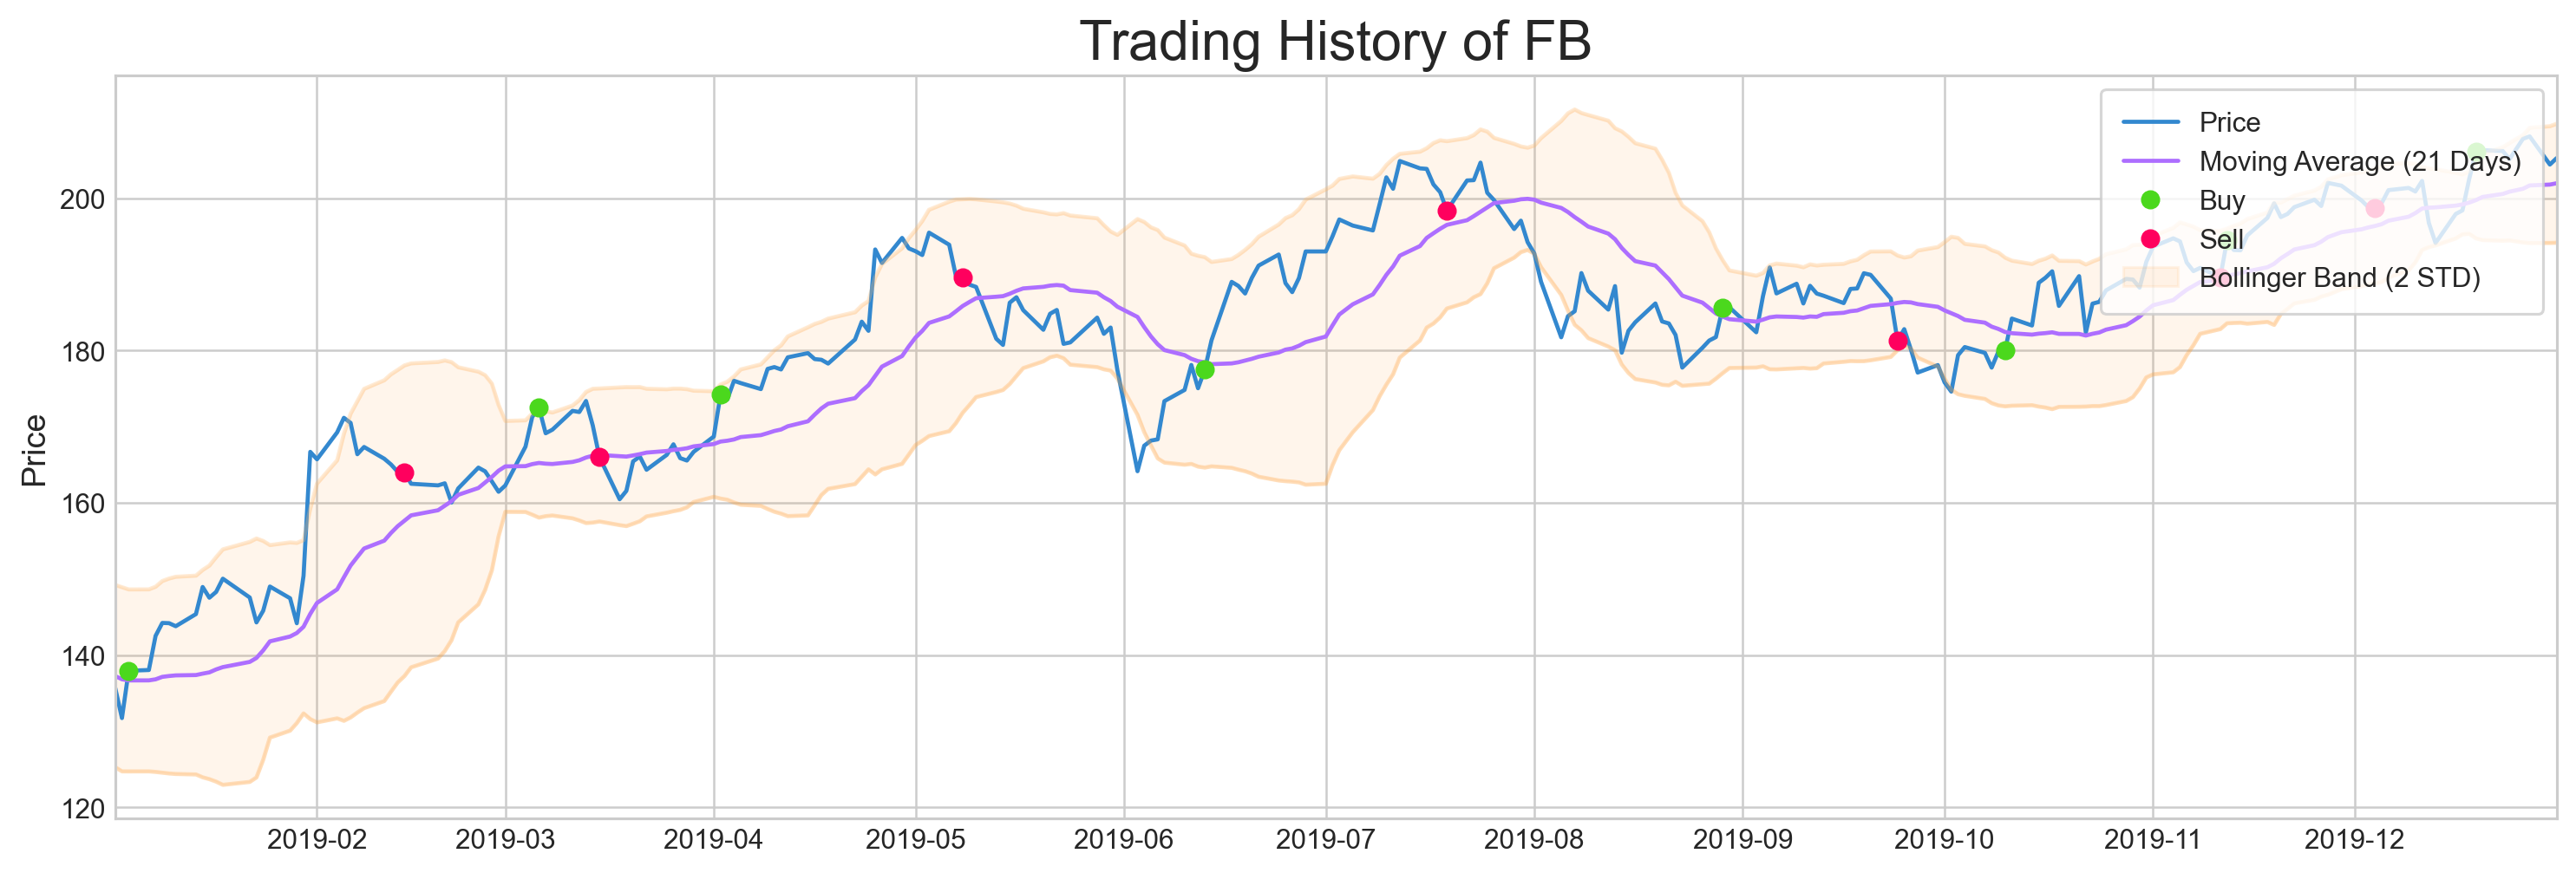

In [12]:
profits, trades = macd_trading(stocks[ticker.lower()].loc[year:year], budget)

In [7]:
def macd_plotting(stock):
    plt.figure(figsize=(16,3))
    plt.plot(stock.MACD, label='MACD', color=purple)
    plt.plot(stock.Signal, label='Signal', color=orange)
    plt.axhline(0, color=black)
    
    plt.legend(frameon=True, loc=1, ncol=1, fontsize=10, borderpad=.8)
    plt.title('MACD of {}'.format(ticker.upper()), fontsize=20)
    plt.ylabel('Strength', fontsize=15)
    plt.show()

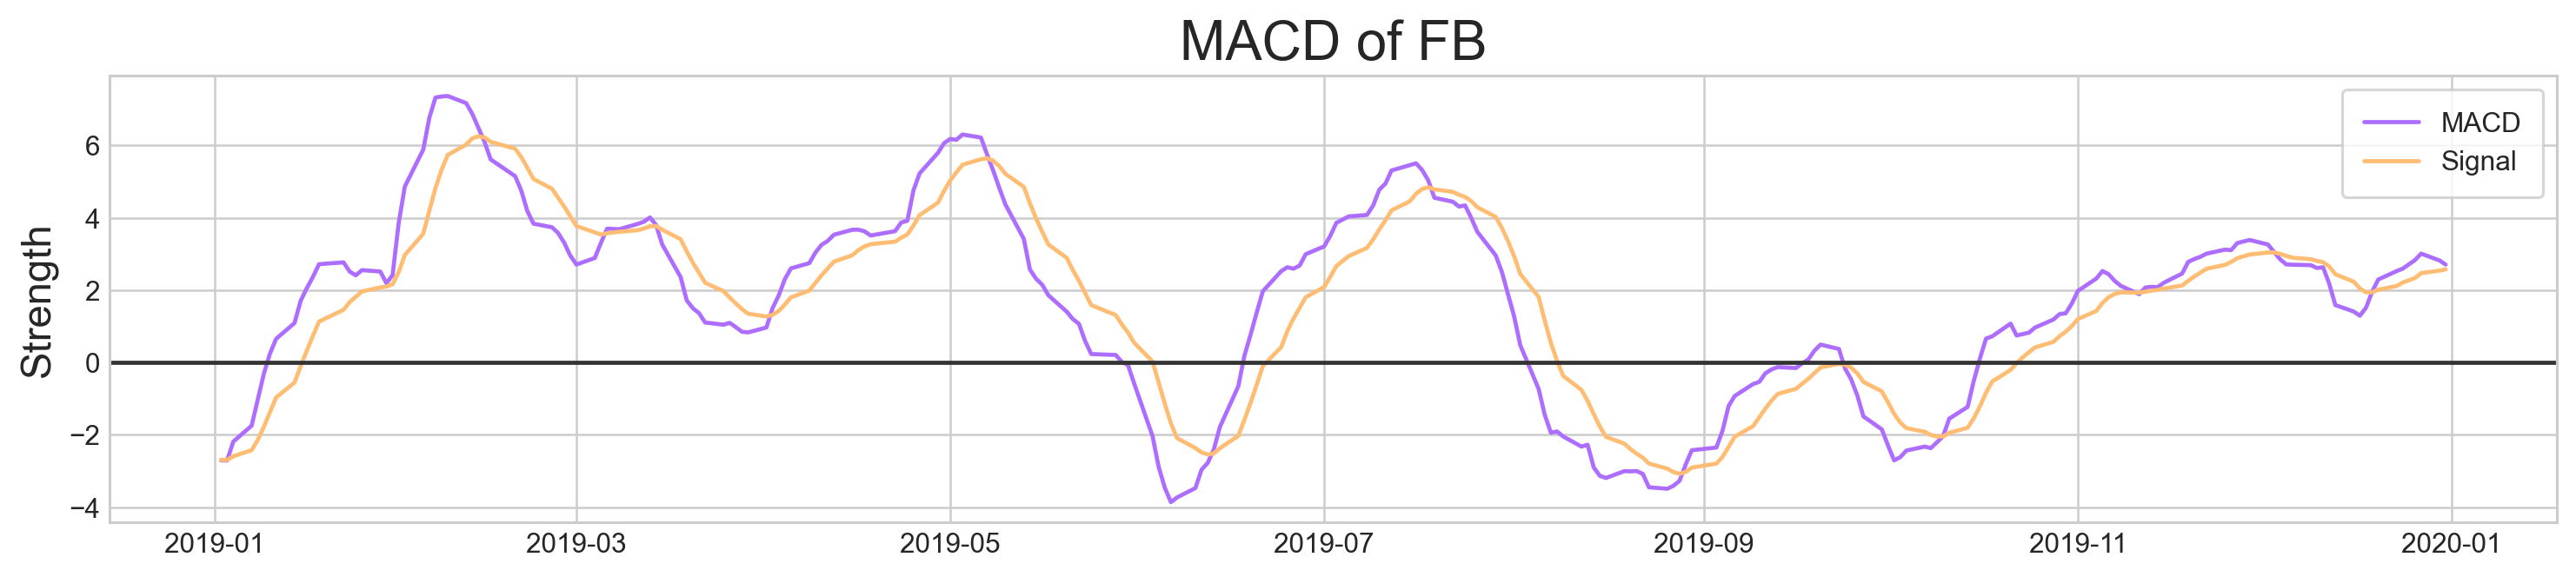

In [8]:
macd_plotting(stocks[ticker.lower()].loc[year:year])

### Returns
- lose money with MACD

In [13]:
companies = [i for i in stocks]
returns = []

for i in stocks: 
    profit, trades = macd_trading(
                stocks[i].loc[year:year],
                budget = budgetM,
                show_graph = False,
                show_return = False
    )
    returns.append(round(profit*100 / budgetM, 2))

In [14]:
pd.DataFrame({'Company':companies, 'Return (%)':returns}).sort_values(by='Return (%)', ascending=False)

,Company,Return (%)
1,fb,41.49
4,aapl,25.47
2,nflx,-27.29
3,goog,-46.05
0,amzn,-76.12


---
# Bollinger Bands to Make Decisions
---

In [24]:
def bb_trading(stock, budget=budgetM, u=0.03, l=0.03, show_graph=True,show_return=True):
    
    money = budget
    stock = stock.reset_index()
    net = []
    for i in range(len(stock)):
        today = stock.iloc[i]
        
        #BUY
        if today.Close < today.MA21 and (abs(1 - today.Close/today.Lower_Band) < u):
            if money > 0:
                stock_amt = int(money/today.Close)
                money=0
                net.append([today.Date, today.Close, 1, stock_amt*today.Close])
        #SELL
        if today.Close > today.MA21 and (abs(1 - today.Upper_Band/today.Close) < l):
            if money == 0:
                money = stock_amt * today.Close
                stock_amt = 0 
                net.append([today.Date, today.Close, 0, money])
    profit = net[-1][3] - budget 
    
    if show_return == True:
        print('Number of Trades: ', len(net))
        print('Time Frame: {} days'.format((net[-1][0] - net[0][0]).days))
        print('Profit: ${:.2f} | {}%'.format(profit, round(profit/budget * 100, 2)))
        
    if show_graph == True: 
        trading_history(stock.set_index('Date'), net)
        
    return profit, net

Number of Trades:  14
Time Frame: 292 days
Profit: $2212.50 | 14.75%


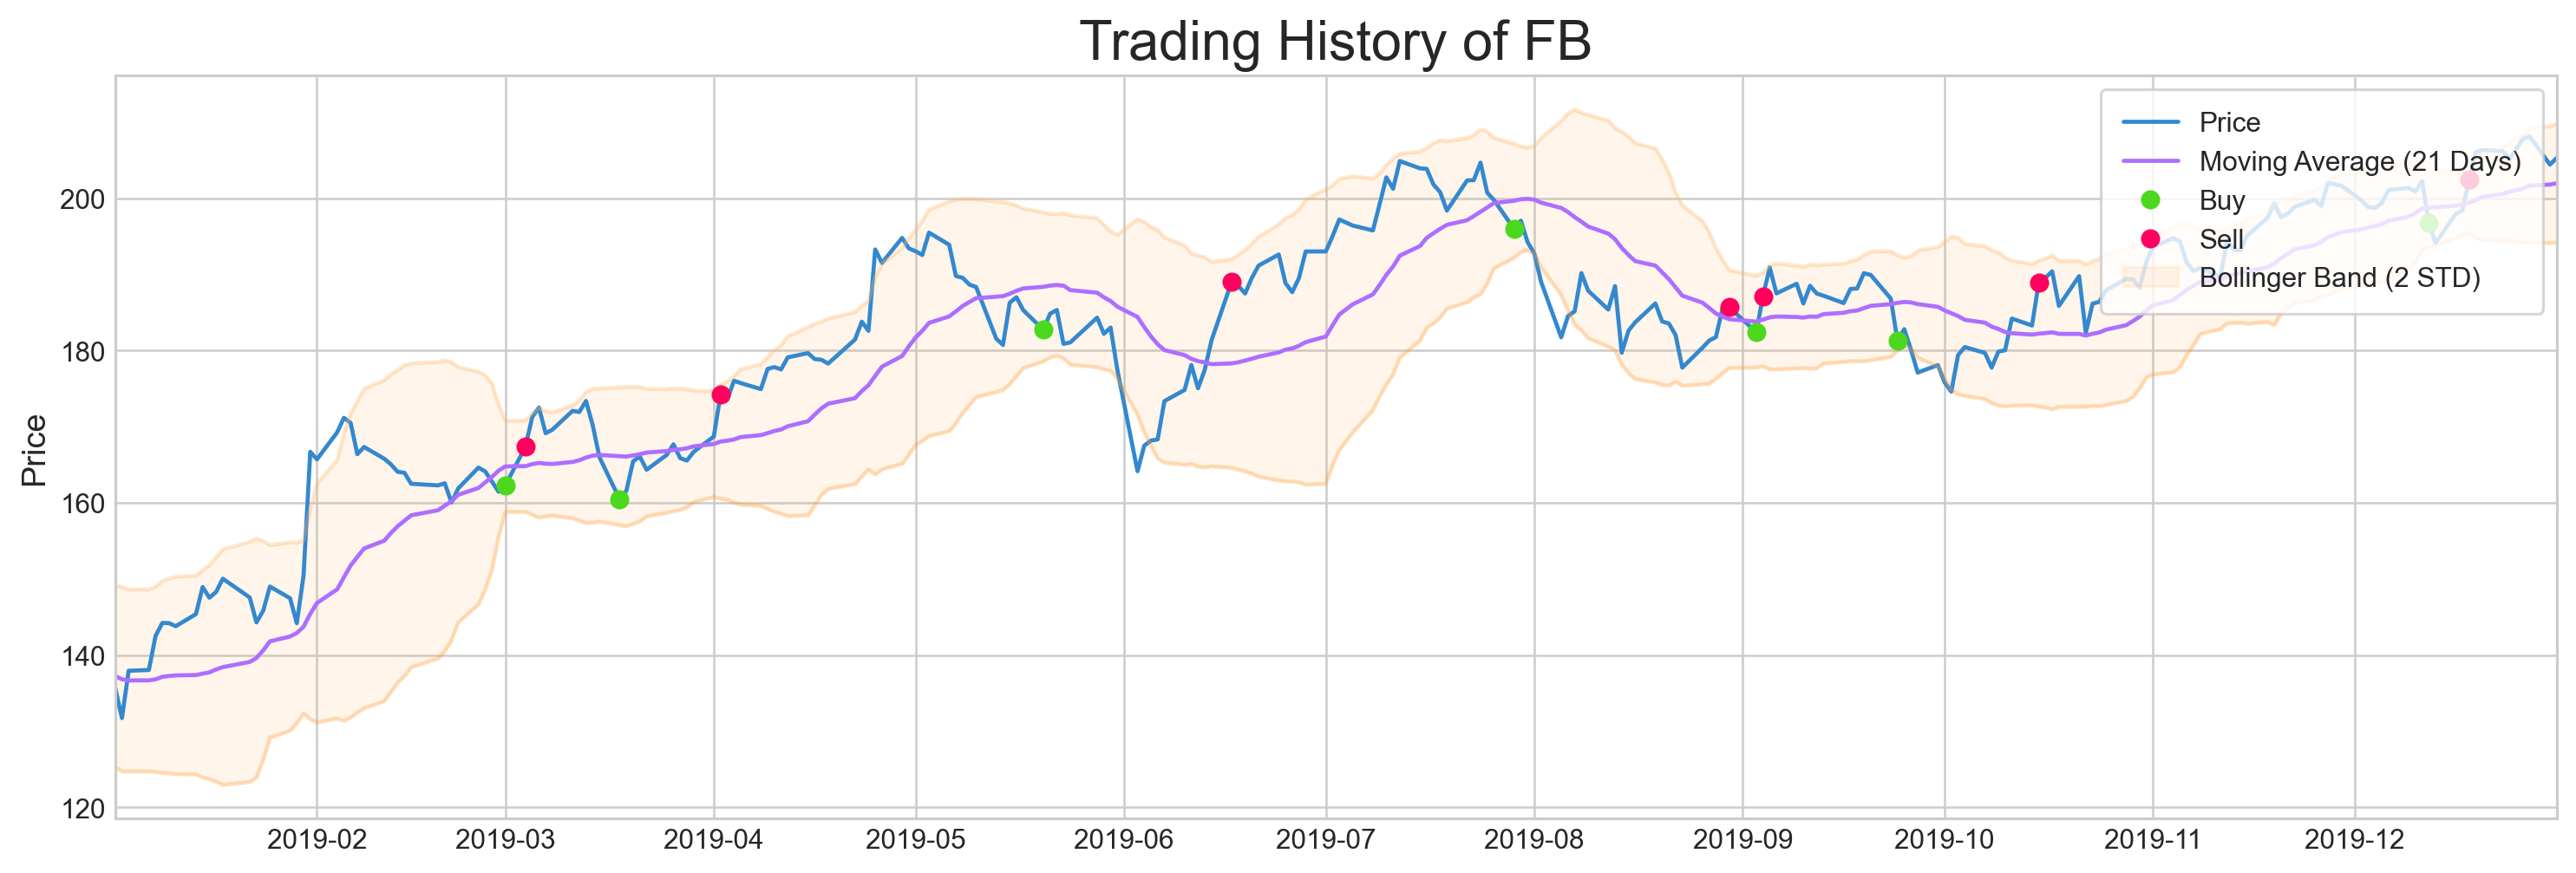

In [25]:
profit, trades = bb_trading(stocks[ticker.lower()].loc[year:year], u=0.03,l=0.03)

### Returns

In [26]:
companies = [i for i in stocks]
returns = []
for i in stocks:
    profit, trades = bb_trading(
                stocks[i].loc[year:year],
                budget = budgetM,
                u = 0.03,
                l = 0.03,
                show_graph = False,
                show_return=False
    )
    returns.append(round(profit*100 / budgetM, 2))

In [27]:
pd.DataFrame({'Company':companies, 'Return (%)':returns}).sort_values(by='Return (%)', ascending=False)

,Company,Return (%)
1,fb,14.75
4,aapl,11.10
2,nflx,0.95
3,goog,-28.74
0,amzn,-29.56
